TP 2 Noté NLP - Classe 3D/3DG

Chloé PICHEREAU & Clémence ANDRE

TP sur les Transformers

Charger un modèle BERT

Faire la préparation des données avec tokenize de BERT

Faire le finetuning avec BERT

Faire un modèle de classification en utilisant les mebeddings de BERT

In [3]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install torch

In [5]:
#Nos importations :

import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import torch
import transformers as transf
import warnings
warnings.filterwarnings('ignore')

c:\Users\cleme\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Chargement de notre dataset 
df = pd.read_csv('TestReviews.csv')

#On affiche le début du fichier 
print(df.head())

#Ici on a moins de visualistion du dataset car tout a été déjà fait dans le TP1

                                              review  class
0  Fantastic spot for an even or a quite cocktail...      1
1  Love, love, love the calamari. It's so good an...      1
2  Love this place. Stiff martinis and cocktails,...      1
3  It's everything a great cocktail bar should be...      1
4  I came here before a pirates game, so it was a...      1


In [7]:
print(len(df))

#On a 4321 lignes de données

4321


In [8]:
df['class'].value_counts()

class
1    2989
0    1332
Name: count, dtype: int64

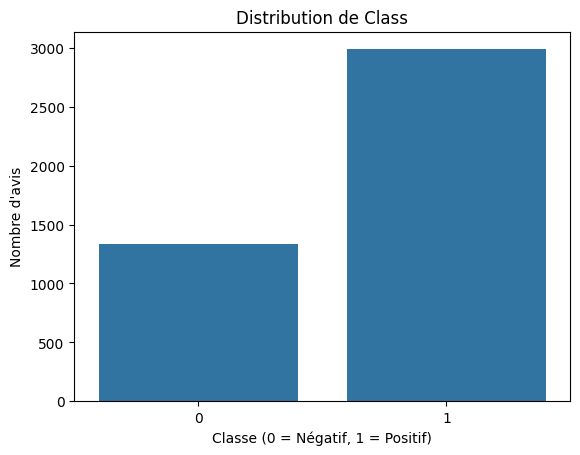

In [9]:
# Visualisation de la distribution de Class
sns.countplot(x='class', data=df)
plt.title('Distribution de Class')
plt.xlabel('Classe (0 = Négatif, 1 = Positif)')
plt.ylabel('Nombre d\'avis')
plt.show()

Echantillonnage des données

In [10]:
#On prend un échantillon de 2000 données

df_sample = df.sample(2000)

In [11]:
#On recompte le nombres d'avis positifs et négatifs dans la classe


df_sample['class'].value_counts()

class
1    1403
0     597
Name: count, dtype: int64

Chargement du modèle DistilBERT et du tokenizer

In [12]:
#On charge le tokenizer et le modèle 

model_class, tokenizer_c, weights_pretrained = (transf.DistilBertModel, transf.DistilBertTokenizer, 'distilbert-base-uncased')

tokenizer = tokenizer_c.from_pretrained(weights_pretrained)
model = model_class.from_pretrained(weights_pretrained)

On prépare le texte

In [13]:
exemple = df_sample.head(5)['review'].values[3]
exemple

"I needed 2 pairs of pants altered in a hurry so I looked on Yelp for a solid place by my house.  I couldn't be happier with this place.  The service, price and quality I received were excellent.  My pants were ready at the date and time promised and there were no issues.  I am glad to have found a great tailor close by and will definitely be back.\n"

In [14]:
print(tokenizer.encode(exemple, add_special_tokens=True))

[101, 1045, 2734, 1016, 7689, 1997, 6471, 8776, 1999, 1037, 9241, 2061, 1045, 2246, 2006, 6300, 14277, 2005, 1037, 5024, 2173, 2011, 2026, 2160, 1012, 1045, 2481, 1005, 1056, 2022, 19366, 2007, 2023, 2173, 1012, 1996, 2326, 1010, 3976, 1998, 3737, 1045, 2363, 2020, 6581, 1012, 2026, 6471, 2020, 3201, 2012, 1996, 3058, 1998, 2051, 5763, 1998, 2045, 2020, 2053, 3314, 1012, 1045, 2572, 5580, 2000, 2031, 2179, 1037, 2307, 22701, 2485, 2011, 1998, 2097, 5791, 2022, 2067, 1012, 102]


In [15]:
tokenized = df_sample['review'].apply((lambda x : tokenizer.encode(x, add_special_tokens=True)))

Token indices sequence length is longer than the specified maximum sequence length for this model (575 > 512). Running this sequence through the model will result in indexing errors


In [16]:
tokenized

913     [101, 1045, 1005, 1049, 2428, 2025, 2469, 2339...
2700    [101, 2023, 2307, 2210, 4497, 2003, 2041, 1997...
995     [101, 3841, 19190, 5162, 2003, 2011, 2521, 225...
2595    [101, 1045, 2734, 1016, 7689, 1997, 6471, 8776...
4186    [101, 5409, 3325, 2412, 999, 2009, 1005, 1055,...
                              ...                        
1280    [101, 2023, 2173, 2323, 2031, 1037, 2843, 2062...
427     [101, 2023, 2003, 2107, 4569, 3573, 999, 1045,...
3128    [101, 1045, 2572, 2013, 3190, 1998, 1045, 2514...
3580    [101, 1045, 2202, 3071, 2008, 3310, 2000, 3942...
3291    [101, 1045, 2442, 2031, 2042, 2045, 2006, 1037...
Name: review, Length: 2000, dtype: object

Calcul de la longueur maximale des séquences

In [17]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

max_len

1108

In [18]:
tokenized_zeroes = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [19]:
np.array(tokenized_zeroes).shape

(2000, 1108)

Création du masque d'attention pour le modèle

In [20]:
attention_mask = np.where(tokenized_zeroes != 0,1,0)
attention_mask

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [21]:
input_ids = torch.tensor(tokenized_zeroes)
attention_mask = torch.tensor(attention_mask)

Conversion en tenseurs pour PyTorch

In [22]:
input_ids

tensor([[  101,  1045,  1005,  ...,     0,     0,     0],
        [  101,  2023,  2307,  ...,     0,     0,     0],
        [  101,  3841, 19190,  ...,     0,     0,     0],
        ...,
        [  101,  1045,  2572,  ...,     0,     0,     0],
        [  101,  1045,  2202,  ...,     0,     0,     0],
        [  101,  1045,  2442,  ...,     0,     0,     0]], dtype=torch.int32)

In [23]:
print(input_ids.shape)  # Devrait être (batch_size, seq_len)
print(attention_mask.shape)  # Devrait être (batch_size, seq_len)

#on voit que le taille de nos tensors sont de 1093 et ne correspondent pas à la taille maximale attendue par le modèle de distilBERT qui est de 512 donc on va tronquer manuellement 

torch.Size([2000, 1108])
torch.Size([2000, 1108])


In [24]:
input_ids = input_ids[:, :100]  # Tronque à 100 tokens
attention_mask = attention_mask[:, :100]

In [25]:
with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask = attention_mask)

Extraction des embeddings avec DistilBERT

In [26]:
features = last_hidden_states[0][:,0,:]

In [27]:
features.shape

torch.Size([2000, 768])

In [28]:
labels = df_sample['class']

Model Train/Test

In [29]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

Entraînement d'un modèle de régression logistique

In [30]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)

LogisticRegression()

In [31]:
lr_clf.score(test_features, test_labels)

0.922

Chargement du modèle DistilBERT et du tokenizer

In [32]:
#Prédiction
text = tokenizer.encode("it's a good product, but i don't like it", add_special_tokens=True, truncation=True, max_length=512)
tokenized_zeroes = np.array([text + [0] * (512 - len(text))])  # max_length explicite pour éviter les dépassements -> on a eu cette erreur juste avant
input_ids = torch.tensor(tokenized_zeroes)
attention_mask = torch.tensor(np.where(tokenized_zeroes != 0, 1, 0))

with torch.no_grad():
    pred_hidden_states = model(input_ids, attention_mask=attention_mask)

features = pred_hidden_states.last_hidden_state[:, 0, :] 

In [33]:
lr_clf.predict(features)

array([1], dtype=int64)

In [34]:
lr_clf.predict_proba(features)

array([[0.46281099, 0.53718901]])

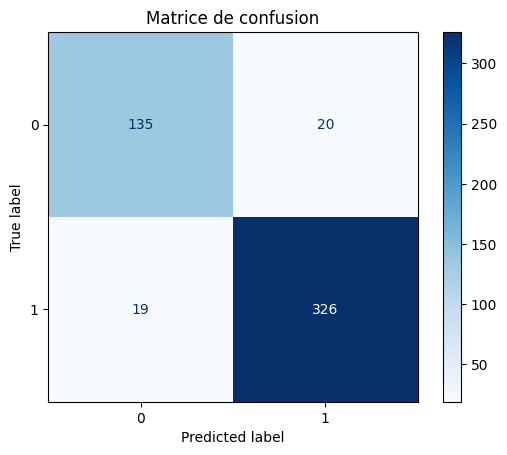

In [36]:
# Analyse des résultats obtenus :
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Matrice de confusion
y_pred = lr_clf.predict(test_features)
cm = confusion_matrix(test_labels, y_pred, labels=lr_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_clf.classes_)
disp.plot(cmap='Blues')
plt.title('Matrice de confusion')
plt.show()


On voit que la matrice de prédiction est plutôt bonne, cependant, au vue des résultats de prédictions qui eux sont mauvais, on préfèrera le modèle du TP1 